In [501]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Customized modules
HOME = '/home/serinatan/project/GPU-Virtualization-Benchmarks/util'
if HOME not in sys.path:
    sys.path.append(HOME)

import data.scripts.common.format as fmt
import data.scripts.common.constants as const
import data.scripts.gen_tables.gen_pair_configs as gen_pair
import data.scripts.gen_tables.gen_table_pair as gen_table_pair
import data.scripts.predict.predict_slowdown as predict

SCRIPT_PATH = os.path.join(HOME, 'data/scripts') 
PKL_PATH = os.path.join(HOME, 'data/pickles') 
CSV_PATH = os.path.join(HOME, 'data/csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
def draw_table(df, cols, hide_index=True):
    if hide_index:
        return df[cols].style.set_table_styles(fmt.table_style).hide_index()
    else:
        return df[cols].style.set_table_styles(fmt.table_style)

# Pair - dynamic

In [491]:
gen_pair = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_pair.py')
baseline = 'seq'
seq_pkl = os.path.join(PKL_PATH, 'seq.pkl')
intra_pkl = os.path.join(PKL_PATH, 'intra.pkl')
csv = os.path.join(HOME, 'data/csv/pair_dynamic.csv')
output = os.path.join(PKL_PATH, 'pair_dynamic_seq.pkl')

%run $gen_pair --csv $csv --output $output --seq_pkl $seq_pkl --intra_pkl $intra_pkl 

In [492]:
df_dynamic = pd.read_pickle(output)
df_dynamic.sort_values(['1_bench', '2_bench'], inplace=True)
df_dynamic.reset_index(inplace=True, drop=True)
print(df_dynamic.shape)

# FIXME: drop any rows with zero fairness
df_dynamic = df_dynamic[df_dynamic['fairness'] > 0]
print(df_dynamic.shape)


(1845, 211)
(1845, 211)


# Prediction Model

In [493]:
X, y = predict.prepare_datasets(df_dynamic, cc=False)
model = predict.train(X, y)

X invalid? False
y invalid? False
X invalid? False
y invalid? False
(3690, 7) (3690,)
K-fold l1 error: 0.03251559658985103
K-fold l1 error: 0.03337581143397477
K-fold l1 error: 0.035463499219757985
K-fold l1 error: 0.03515640283580544
K-fold l1 error: 0.0323043302955595


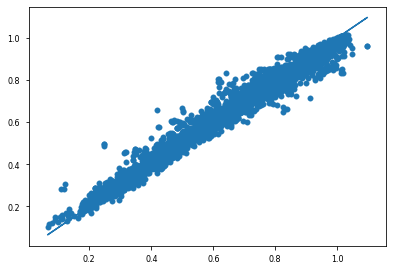

In [494]:
plt.scatter(y, model.predict(X))
plt.plot(y, y)
plt.show()

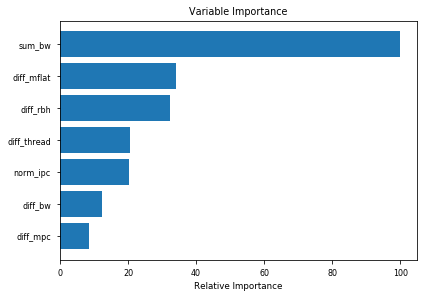

In [495]:
predict.plot_importance(model)

In [496]:
df_dynamic['1_predicted'] = predict.predict_from_df(model, df_dynamic, 'x')
df_dynamic['2_predicted'] = predict.predict_from_df(model, df_dynamic, 'y')

df_dynamic['1_delta'] = df_dynamic['1_predicted'] - df_dynamic['1_sld']
df_dynamic['2_delta'] = df_dynamic['2_predicted'] - df_dynamic['2_sld']

In [529]:
# Only show best performance for each benchmark pair
df_dynamic_show = df_dynamic.sort_values('ws', ascending=False).drop_duplicates(['1_bench','2_bench'])
df_dynamic_show.reset_index(inplace=True, drop=True)

col_dynamic_seq = ['1_bench', 'intra_x', 'l2_x',
                   '2_bench', 'intra_y', 'l2_y',
#                    'norm_ipc_x', 
                   '1_sld', '1_predicted',  #'1_infer', 
                   '1_delta',
#                    'diff_rbh_x', 'diff_mflat_x', 'diff_bw_x', 'diff_mpc_x', 'diff_thread_x', 'l2_miss_rate_x',
#                    'norm_ipc_y', 
                   '2_sld', '2_predicted',  #'2_infer', 
                   '2_delta',
                   'ws', 'fairness', 
#                    'sum_ipc', 'diff_mflat', 'sum_dram',
#                    '1_norm_mflat', '2_norm_mflat'
                  ]
def highlight_error(s):
    is_high = np.abs(s) > 0.1
    return ['background-color: yellow' if v else '' for v in is_high]

draw_table(df_dynamic_show[df_dynamic_show['2_bench']=='rod_lavamd-0'], 
           #df_dynamic[(df_dynamic['1_delta'] > 0.15)|(df_dynamic['2_delta'] > 0.15)], 
           col_dynamic_seq, False).apply(highlight_error, subset=['1_delta', '2_delta'])

,1_bench,intra_x,l2_x,2_bench,intra_y,l2_y,1_sld,1_predicted,1_delta,2_sld,2_predicted,2_delta,ws,fairness
4,parb_lbm-0,6,0.5,rod_lavamd-0,5,0.5,0.929835,0.899812,-0.0300228,1.00899,0.952623,-0.0563625,1.93882,0.921554
13,parb_cutcp-0,2,0.25,rod_lavamd-0,2,0.75,0.903037,0.864357,-0.0386792,0.876262,0.883603,0.00734042,1.7793,0.970351
14,cut_wmma-0,2,0.75,rod_lavamd-0,2,0.25,0.944537,0.837331,-0.107206,0.826648,0.825857,-0.000791497,1.77118,0.875189
21,parb_stencil-0,5,0.5,rod_lavamd-0,3,0.5,0.857657,0.87618,0.0185227,0.745233,0.810347,0.0651144,1.60289,0.868917
37,cut_sgemm-1,1,0.25,rod_lavamd-0,2,0.75,0.618032,0.80279,0.184758,0.623773,0.792842,0.169069,1.24181,0.990796


# L2 partition worth it?

In [522]:
# read csv file unified-l2.csv
df_l2 = pd.read_csv(os.path.join(CSV_PATH, 'unified-l2.csv'))

# split pair into two benchmarks
pair = [re.split(r'-(?=\D)', p) for p in df_l2['pair_str']]
df_bench = pd.DataFrame(pair, columns=['1_bench', '2_bench'])
df_l2 = pd.concat([df_bench, df_l2], axis=1)

df_seq = pd.read_pickle(os.path.join(PKL_PATH, 'seq.pkl'))
df_l2 = gen_table_pair.evaluate_df_pair(df_l2, df_seq)

l2_keep_col = ['1_bench', '2_bench', '1_sld', '2_sld', 'ws', 'fairness']
df_yes_l2 = df_dynamic_show[l2_keep_col]
df_l2 = df_l2[l2_keep_col]

df_merge = pd.merge(df_l2, df_yes_l2, on=['1_bench', '2_bench'])
# draw_table(df_merge, df_merge.columns)

from scipy.stats import mstats
yes_ws = mstats.gmean(df_merge['ws_y'])
no_ws = mstats.gmean(df_merge['ws_x'])
yes_fair = mstats.gmean(df_merge['fairness_y'])
no_fair = mstats.gmean(df_merge['fairness_x'])

print(yes_ws, no_ws)
print(yes_fair, no_fair)

1.5916939808437316 1.5813796047349369
0.7997131123163216 0.8017260683214498
